In [20]:
!pip install pandas
!pip install numpy

!pip install scikit-learn

!pip install torch

!pip install matplotlib
!pip install ipywidgets

In [21]:
from pandas import read_csv
from numpy import linspace, meshgrid, column_stack

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed

# Data import


The dataset is imported from a personal GitHub repository URL and loaded into a DataFrame using the read_csv function. The shape of the dataset is then retrieved, displaying the number of rows and columns.

In [24]:
data = read_csv('https://raw.githubusercontent.com/ricdirenzo/AAI_master_workshops/refs/heads/main/regression/input/heart_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   biking         498 non-null    float64
 1   smoking        498 non-null    float64
 2   heart_disease  498 non-null    float64
dtypes: float64(3)
memory usage: 11.8 KB


# Data preprocessing

The dataset is split into training and testing sets, with 80% of the data used for training and 20% for testing, ensuring reproducibility through a fixed random seed.

In [26]:
X, y = data.iloc[:, [0, 1]].values, data.iloc[:, [-1]].values

# Split data into training (80%) and testing (20%) sets, with reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


It is useful to visualize the data distribution and check for outliers before applying a scaler. This helps in selecting the appropriate scaler (e.g., StandardScaler for normal data, RobustScaler for outliers). Common visualizations include histograms, boxplots, or density plots.

In [27]:
n_features = X_train.shape[1]

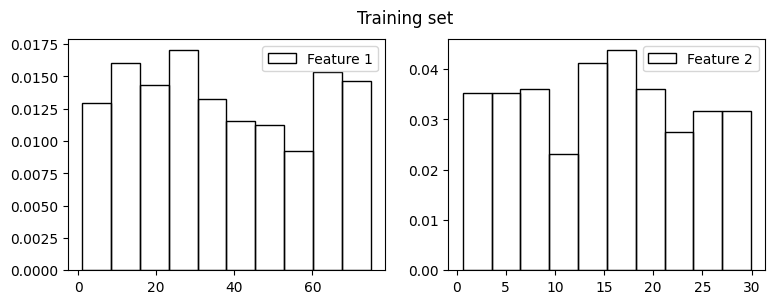

In [28]:
fig, axes = plt.subplots(1, n_features, figsize=(9, 3))

for x in range(n_features):
  axes[x].hist(X_train[:, x],
               facecolor="none", edgecolor="black",
               label=f"Feature {x+1}", density=True)
  axes[x].legend()

plt.suptitle('Training set')
plt.show()

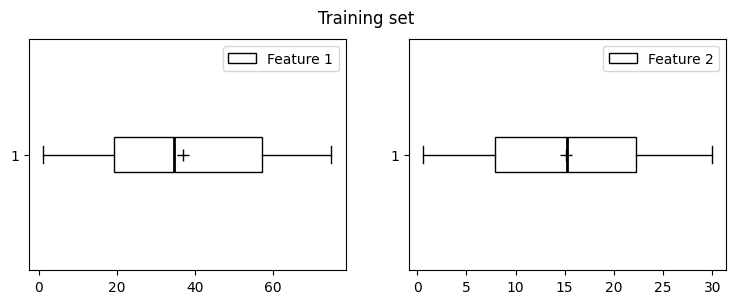

In [29]:
fig, axes = plt.subplots(1, n_features, figsize=(9, 3))

for x in range(n_features):
  axes[x].boxplot(X_train[:, x],
                  patch_artist=True,
                  boxprops=dict(facecolor="None", edgecolor="black"),
                  medianprops=dict(color="black", linewidth=2),
                  meanprops=dict(marker="+", markerfacecolor="black", markeredgecolor="black", markersize=8),
                  showmeans=True,
                  label=f"Feature {x+1}", vert=False)
  axes[x].legend()

plt.suptitle('Training set')
plt.show()

In [30]:
# Initialize the MinMax scaler for feature scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feed-Forward Neural Network Implementation (FFNN)
A Feed-Forward Neural Network is a structure with input, hidden, and output layers where data flows in one direction, and neurons are connected with weighted links and activation functions.





## Data preparation for neural network training

Data is converted into PyTorch tensors with a float32 data type for both training and testing sets.

In [31]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Defining a Simple FFNN

The `SimpleFeedForward` class defines a basic feed-forward neural network in PyTorch. It includes the following components:

1. **Input layer** (`fc1`): a fully connected linear layer that maps input data to a hidden layer with a specified number of features.
2. **Batch normalization** (`batch_norm`): normalizes the input of each mini-batch to have a mean of 0 and a standard deviation of 1. This helps improve training speed and stability by reducing internal covariate shift.

  $$y_i = γ \cdot \frac{x_i-μ_B}{\sqrt{σ_B^2 + ϵ}} + β $$
  where:
  - $x_i$ is the input value for the $i$-th sample in the batch
  - $μ_B$ is the mean of the batch
  - $σ_B^2$ is the variance of the batch
  - $ϵ$ is a small constant added for numerical stability
  - $γ$ is the learned scale parameter
  - $β$ is the learned shift parameter

  `nn.BatchNorm1d(hidden_size)` applies **batch normalization** to a 1D input, commonly used in fully connected (linear) networks. In PyTorch, the `BatchNorm1d` layer automatically handles the computation of the mean, variance, and scaling/shifting during training and evaluation.

3. **Activation function** (`act`): a parametric ReLU (RReLU) activation function is applied after batch normalization to introduce non-linearity.
4. **Output layer** (`fc2`): a final fully connected linear layer that produces the output.

In the `forward` method, the input is passed through these layers in sequence: first `fc1`, then batch normalization, followed by the activation function, and finally through `fc2` to generate the output.

A neural network with 2 input features, 1 hidden layer with 4 neurons, and 1 output. The derived features of the hidden layer are created from linear combinations of the inputs, and the output is created as a linear combination of these derived features.

&nbsp;![Rete neurale](https://www.researchgate.net/profile/Osama-Mohsen/publication/355094551/figure/fig2/AS:1076573407059968@1633686510430/A-neural-network-with-2-input-features-1-hidden-layer-and-1-output-The-derived-features.png)&nbsp;

The process of training a neural network for regression as follows: (**input layer**) for each example in the training set, input features are fed to the neural network and the specified target value is known. (**hidden layer**) Each hidden feature (a node in the hidden layer) is created as the weighted sum of all input features given the connection weights. (**output layer**)

In [32]:
class SimpleFeedForward(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleFeedForward, self).__init__()
    # Input layer
    self.fc1 = nn.Linear(input_size, hidden_size)
    # Batch normalization layer
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    # RReLU activation function for the hidden layer
    self.act = nn.RReLU()
    # Output layer, no activation
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # Pass input through the first layer
    res = self.fc1(x)
    # Apply batch normalization
    res = self.batch_norm(res)
    # Apply the ReLU activation function
    res = self.act(res)
    # Pass through the output layer
    res = self.fc2(res)
    return res

## Neural network architecture and model initialization  

A neural network architecture is initialized using the `SimpleFeedForward` class defined above, with 2 input features (x1, x2), a hidden layer consisting of 4 neurons, and a single output (y).

In [33]:
# Two input features: x1 and x2
input_size = 2
# Hidden layer with 4 neurons
hidden_size = 4
# Single output: y
output_size = 1

model = SimpleFeedForward(input_size, hidden_size, output_size)

## Loss, optimizer, and scheduler setup

The model uses the `MSELoss` (Mean Squared Error) loss function to measure the difference between predicted and actual values. Stochastic Gradient Descent (`SGD`) with a learning rate of 0.01 is used to optimize the model's parameters. To improve training, a learning rate scheduler reduces the learning rate by half (`gamma=0.5`) every 20 epochs (`step_size=20`), allowing for finer updates as the training progresses, improving convergence.

In [34]:
# Mean Squared Error for regression
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduce LR by half every 20 epochs

## Model training and loss tracking

A training loop is implemented for a PyTorch model over 200 epochs. Each epoch begins with setting the model to training mode, followed by a forward pass to generate predictions. The loss is computed based on the predictions and true values, after which the gradients are cleared, and the optimizer updates the model's weights through backpropagation. The learning rate scheduler is stepped at each epoch to adjust the learning rate. Every 10 epochs, the loss value is tracked and printed, along with the current learning rate, enabling progress monitoring and optimization evaluation.

In [35]:
epochs = 200

loss_values = []

for epoch in range(epochs):
    model.train()

    # ------ Forward pass ---------------------
    y_pred = model(X_train)

    # ------ Backward pass and optimization ---
    # Compute the loss
    loss = criterion(y_pred, y_train)

    # Clear the gradients
    optimizer.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the model weights
    optimizer.step()

    # Step the learning rate scheduler
    scheduler.step()

    loss_values.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1:>{len(str(epochs))}}/{epochs}], ',
              f'Loss: {loss.item():>{8}.4f}, ',
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [ 10/200],  Loss:  52.4183,  Learning Rate: 0.010000
Epoch [ 20/200],  Loss:   1.8261,  Learning Rate: 0.005000
Epoch [ 30/200],  Loss:   0.9182,  Learning Rate: 0.005000
Epoch [ 40/200],  Loss:   0.8050,  Learning Rate: 0.002500
Epoch [ 50/200],  Loss:   0.7728,  Learning Rate: 0.002500
Epoch [ 60/200],  Loss:   0.7412,  Learning Rate: 0.001250
Epoch [ 70/200],  Loss:   0.7122,  Learning Rate: 0.001250
Epoch [ 80/200],  Loss:   0.7238,  Learning Rate: 0.000625
Epoch [ 90/200],  Loss:   0.7219,  Learning Rate: 0.000625
Epoch [100/200],  Loss:   0.6987,  Learning Rate: 0.000313
Epoch [110/200],  Loss:   0.7169,  Learning Rate: 0.000313
Epoch [120/200],  Loss:   0.7000,  Learning Rate: 0.000156
Epoch [130/200],  Loss:   0.7211,  Learning Rate: 0.000156
Epoch [140/200],  Loss:   0.7214,  Learning Rate: 0.000078
Epoch [150/200],  Loss:   0.7072,  Learning Rate: 0.000078
Epoch [160/200],  Loss:   0.7077,  Learning Rate: 0.000039
Epoch [170/200],  Loss:   0.7057,  Learning Rate: 0.0000

A plot is generated with loss_values displayed as a red line. The x-axis is labeled "Epochs" and the y-axis is labeled "Loss".

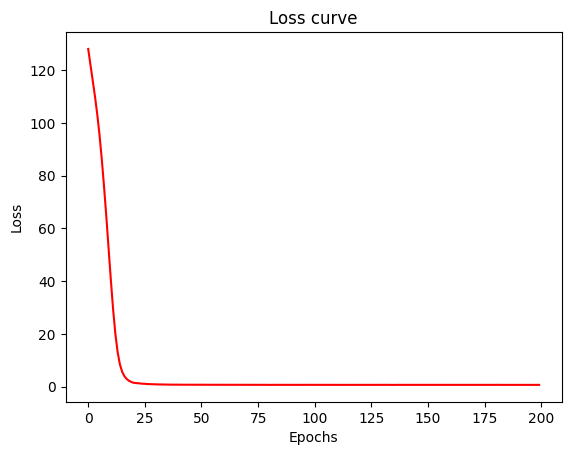

In [36]:
plt.plot(loss_values, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()

## Model evaluation

Predictions are generated on the test data by setting the model to evaluation mode and passing the test input through the model. The R-squared value is then computed using scikit-learn's `r2_score` function, comparing the true target values (`y_test`) with the predicted values (`y_pred`). The predictions are first detached, and the tensors are converted to numpy arrays before calculating the R-squared metric.

In [37]:
# Calculate predictions on the test data
model.eval()  # Set the model to evaluation mode
y_pred = model(X_test)

# Calculate R-squared using scikit-learn
r2 = r2_score(y_test.numpy(), y_pred.detach().numpy())

print(f"R-squared: {r2:.4f}")

R-squared: 0.9563


## Visualize regression surface fit

A 3D plot is generated to visually represent a regression surface along with the training data points. First, a grid is created based on the range of the input features, X, by defining a set of x and y values and using them to form a meshgrid. These grid points are then rescaled back to the same scale as the training data using a given scaler. This rescaled data is passed through the model to obtain the predicted output, which forms the z-values for the regression surface.

A figure is then created using `matplotlib`, and a 3D subplot is initialized. The training data points are plotted as a scatter plot in black, while the regression surface is plotted as a blue surface, with some transparency applied to both to enhance the visual clarity.

Finally, the view angle is adjusted by setting the azimuthal and elevation angles of the plot, allowing for an interactive exploration of the surface's fit to the data. The resulting plot provides a clear visual representation of how well the model fits the 3D data.

In [38]:
def plot_regression_surface_interactive(model, X, y, scaler, azim=270, elev=0):
    # Create the grid for the regression surface
    x_range = linspace(X[:, 0].min(), X[:, 0].max(), 50)
    y_range = linspace(X[:, 1].min(), X[:, 1].max(), 50)
    x_grid, y_grid = meshgrid(x_range, y_range)

    # Rescale the grid (invert normalization)
    grid_data = column_stack((x_grid.ravel(), y_grid.ravel()))
    grid_data_scaled = scaler.transform(grid_data)  # Normalize the grid
    grid_tensor = torch.tensor(grid_data_scaled, dtype=torch.float32)

    # Model predictions on the grid
    with torch.no_grad():
        z_grid = model(grid_tensor).numpy().reshape(x_grid.shape)

    # Create the figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Real data (scatter plot)
    ax.scatter(X[:, 0], X[:, 1], y, color='k', marker='o', alpha=0.75, label="Training set")

    # Regression surface
    ax.plot_surface(x_grid, y_grid, z_grid, color='b', alpha=0.75, label="Regression surface")

    # Set the view angle
    ax.view_init(azim=azim, elev=elev)

    # Labels and title
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.set_title('3D Regression surface')

    plt.legend()
    plt.show()

In [39]:
X_real = data.iloc[:, [0, 1]].values
y_real = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

# Example scaler (replace with your actual scaler if necessary)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_train)

# Assuming 'model' is your trained model
interactive_plot = interactive(plot_regression_surface_interactive,
                               model=fixed(model),
                               X=fixed(X_train),
                               y=fixed(y_train),
                               scaler=fixed(scaler),
                               azim=(0, 360, 1),
                               elev=(-90, 90, 1))

# Display the interactive plot
interactive_plot

interactive(children=(IntSlider(value=270, description='azim', max=360), IntSlider(value=0, description='elev'…

# Conclusions

In summary, the model suggests that biking (x1) could lower the risk of heart disease, with higher levels of physical activity associated with a reduced risk. On the other hand, smoking (x2) could significantly increase the likelihood of developing heart disease. Both factors are statistically significant and highlight the importance of regular physical activity and smoking cessation for the prevention of cardiovascular diseases.